In [77]:
import random
import heapq
import math
import sys
import time
from collections import defaultdict, deque, Counter
from itertools import combinations
from IPython.display import clear_output

import chess
import chess.engine

import numpy as np
import pandas as pd

## Recalling the infrastructure from HW 1 (copy and paste)

In [78]:
class Game():
    """A game is similar to a problem, but it has a terminal test instead of 
    a goal test, and a utility for each terminal state. To create a game, 
    subclass this class and implement `actions`, `result`, `is_terminal`, 
    and `h`."""

    def actions(self, state):
        """Return a collection of the allowable moves from this state."""
        raise NotImplementedError

    def result(self, state, move):
        """Return the state that results from making a move from a state."""
        raise NotImplementedError

    def is_terminal(self, state):
        """Return True if this is a final state for the game."""
        return not self.actions(state)
        
    def get_player(self, state):
        """Returns the player whose turn it is"""
        raise NotImplementedError
        
    def get_turn(self, state):
        """Returns the turn of the player that has to make a move"""
        raise NotImplementedError
        

In [79]:
#
# Chess game
#
class Chess(Game):
    """Instantiate a chess game with a fresh chess.Board()
       Game state is represented by the fen of the board"""
    
    def __init__(self):
        self.initial = chess.Board().fen()
        
    def actions(self, state):
        board = self.get_board(state)
        return board.legal_moves
    
    def result(self, state, action):
        board = self.get_board(state)
        board.push(action)
        return board.fen()

    def undo_move(self, state):
        board = self.get_board(state)
        board.pop()
    
    def is_terminal(self, state):
        board = self.get_board(state)
        outcome = board.outcome();
        if (outcome != None):
            return True;
        else:
            return False
        
    def display(self, state):
        board = self.get_board(state)
        display(board)
        
    def get_board(self, state):
        """Given a FEN state, returns the actual board"""
        return chess.Board(state)  
    
    def get_player(self, state):
        """Returns the player whose turn it is"""
        board = self.get_board(state)
        return 'White' if board.turn else 'Black'
    
    def get_turn(self, state):
        return self.get_board(state).turn
    
    def get_move(self, move_str):
        """Transform a string to a Move object"""
        move = None
        if len(move_str) == 4 or len(move_str) == 5:
            try:
                move = chess.Move.from_uci(move_str)
            except ValueError:
                move = None
                # do nothing
        return move
        

In [80]:
class Heuristics():
    """This abstract class has to be implemented to define the heuristic
       evaluation for a particular game. All logic related to the evaluation
       should be defined here"""
     
    def h1(self, state):
        """This is the first heuristic. There should be atleast one"""
        raise NotImplementedError

In [81]:
class ChessHeuristics(Heuristics):
    """Class where all the chess heuristic are defined"""
    
    def __init__(self):
        self.weights = np.array([1.2, 1.2, 1.2, 0.9, 0.9, 0.6])
        self.pieces_value = {
            'p': 100, 'P': 100,
            'n': 280, 'N': 280,
            'b': 320, 'B': 320,
            'r': 479, 'R': 479,
            'q': 929, 'Q': 929,
            'k': 60000, 'K': 60000,
        }
        self.squares_value = {
            'P': (  0,   0,   0,   0,   0,   0,   0,   0,
                    -31,   8,  -7, -37, -36, -14,   3, -31,
                    -22,   9,   5, -11, -10,  -2,   3, -19,
                    -26,   3,  10,   9,   6,   1,   0, -23,
                    -17,  16,  -2,  15,  14,   0,  15, -13,
                    7,  29,  21,  44,  40,  31,  44,   7,
                    78,  83,  86,  73, 102,  82,  85,  90,
                    0,   0,   0,   0,   0,   0,   0,   0),

            'N': (  -74, -23, -26, -24, -19, -35, -22, -69,
                    -23, -15,   2,   0,   2,   0, -23, -20,
                    -18,  10,  13,  22,  18,  15,  11, -14,
                    -1,   5,  31,  21,  22,  35,   2,   0,
                    24,  24,  45,  37,  33,  41,  25,  17,
                    10,  67,   1,  74,  73,  27,  62,  -2,
                    -3,  -6, 100, -36,   4,  62,  -4, -14,
                    -66, -53, -75, -75, -10, -55, -58, -70),

            'B': (  -7,   2, -15, -12, -14, -15, -10, -10,
                    19,  20,  11,   6,   7,   6,  20,  16,
                    14,  25,  24,  15,   8,  25,  20,  15,
                    13,  10,  17,  23,  17,  16,   0,   7,
                    25,  17,  20,  34,  26,  25,  15,  10,
                    -9,  39, -32,  41,  52, -10,  28, -14,
                    -11,  20,  35, -42, -39,  31,   2, -22,
                    -59, -78, -82, -76, -23,-107, -37, -50),

            'R': (  -30, -24, -18,   5,  -2, -18, -31, -32,
                    -53, -38, -31, -26, -29, -43, -44, -53,
                    -42, -28, -42, -25, -25, -35, -26, -46,
                    -28, -35, -16, -21, -13, -29, -46, -30,
                    0,   5,  16,  13,  18,  -4,  -9,  -6,
                    19,  35,  28,  33,  45,  27,  25,  15,
                    55,  29,  56,  67,  55,  62,  34,  60,
                    35,  29,  33,   4,  37,  33,  56,  50),

            'Q': (  -39, -30, -31, -13, -31, -36, -34, -42,
                    -36, -18,   0, -19, -15, -15, -21, -38,
                    -30,  -6, -13, -11, -16, -11, -16, -27,
                    -14, -15,  -2,  -5,  -1, -10, -20, -22,
                    1, -16,  22,  17,  25,  20, -13,  -6,
                    -2,  43,  32,  60,  72,  63,  43,   2,
                    14,  32,  60, -10,  20,  76,  57,  24,
                    6,   1,  -8,-104,  69,  24,  88,  26),

            'K': (  17,  30,  -3, -14,   6,  -1,  40,  18,
                    -4,   3, -14, -50, -57, -18,  13,   4,
                    -47, -42, -43, -79, -64, -32, -29, -32,
                    -55, -43, -52, -28, -51, -47,  -8, -50,
                    -55,  50,  11,  -4, -19,  13,   0, -49,
                    -62,  12, -57,  44, -67,  28,  37, -31,
                    -32,  10,  55,  56,  56,  55,  10,   3,
                    4,  54,  47, -99, -99,  60,  83, -62),

            'p': (   0,   0,   0,   0,   0,   0,   0,   0,
                    78,  83,  86,  73, 102,  82,  85,  90,
                     7,  29,  21,  44,  40,  31,  44,   7,
                   -17,  16,  -2,  15,  14,   0,  15, -13,
                   -26,   3,  10,   9,   6,   1,   0, -23,
                   -22,   9,   5, -11, -10,  -2,   3, -19,
                   -31,   8,  -7, -37, -36, -14,   3, -31,
                     0,   0,   0,   0,   0,   0,   0,   0),

            'n': ( -66, -53, -75, -75, -10, -55, -58, -70,
                    -3,  -6, 100, -36,   4,  62,  -4, -14,
                    10,  67,   1,  74,  73,  27,  62,  -2,
                    24,  24,  45,  37,  33,  41,  25,  17,
                    -1,   5,  31,  21,  22,  35,   2,   0,
                   -18,  10,  13,  22,  18,  15,  11, -14,
                   -23, -15,   2,   0,   2,   0, -23, -20,
                   -74, -23, -26, -24, -19, -35, -22, -69),

            'b': ( -59, -78, -82, -76, -23,-107, -37, -50,
                   -11,  20,  35, -42, -39,  31,   2, -22,
                    -9,  39, -32,  41,  52, -10,  28, -14,
                    25,  17,  20,  34,  26,  25,  15,  10,
                    13,  10,  17,  23,  17,  16,   0,   7,
                    14,  25,  24,  15,   8,  25,  20,  15,
                    19,  20,  11,   6,   7,   6,  20,  16,
                    -7,   2, -15, -12, -14, -15, -10, -10),

            'r': (  35,  29,  33,   4,  37,  33,  56,  50,
                    55,  29,  56,  67,  55,  62,  34,  60,
                    19,  35,  28,  33,  45,  27,  25,  15,
                     0,   5,  16,  13,  18,  -4,  -9,  -6,
                   -28, -35, -16, -21, -13, -29, -46, -30,
                   -42, -28, -42, -25, -25, -35, -26, -46,
                   -53, -38, -31, -26, -29, -43, -44, -53,
                   -30, -24, -18,   5,  -2, -18, -31, -32),

            'q': (   6,   1,  -8,-104,  69,  24,  88,  26,
                    14,  32,  60, -10,  20,  76,  57,  24,
                    -2,  43,  32,  60,  72,  63,  43,   2,
                     1, -16,  22,  17,  25,  20, -13,  -6,
                   -14, -15,  -2,  -5,  -1, -10, -20, -22,
                   -30,  -6, -13, -11, -16, -11, -16, -27,
                   -36, -18,   0, -19, -15, -15, -21, -38,
                   -39, -30, -31, -13, -31, -36, -34, -42),

            'k': (   4,  54,  47, -99, -99,  60,  83, -62,
                   -32,  10,  55,  56,  56,  55,  10,   3,
                   -62,  12, -57,  44, -67,  28,  37, -31,
                   -55,  50,  11,  -4, -19,  13,   0, -49,
                   -55, -43, -52, -28, -51, -47,  -8, -50,
                   -47, -42, -43, -79, -64, -32, -29, -32,
                    -4,   3, -14, -50, -57, -18,  13,   4,
                    17,  30,  -3, -14,   6,  -1,  40,  18)}
        
        
    def h1(self, board):
        """Random pick; given a state, this heuristic returns a random number
        that randomize the action pick if all evaluations are the same"""
        bonus = round(random.random(), 2)*10
        return bonus
    
    def h2(self, board):
        """Checkmate heuristic; if state is checkmate receives big reward"""
        value = 0;
        if (board.is_checkmate()):
            value += 9999
        return value
    
    def h3(self, board):
        """Check heuristic; it rewards a little the states with a check on the king"""
        
        value = 0;
        if (board.is_check()):
            value += 25
        return value
    
    def h4(self, board):
        """White pieces evaluation; it assign values based on the number and quality of the pieces"""
        value_white = 0
        
        pieces = board.piece_map()
        
        for p in pieces:
            if(str(pieces[p]).isupper()):
                value_white += self.pieces_value[str(pieces[p])]
                       
        return value_white if not board.turn else - value_white
                
    def h5(self, board):
        """Black pieces evaluation; it assign values based on the number and quality of the pieces"""
        value_black = 0
        
        pieces = board.piece_map()
        
        for p in pieces:
            if(not str(pieces[p]).isupper()):
                value_black += self.pieces_value[str(pieces[p])]
     
        return value_black if board.turn else - value_black
    
    def h6(self, board):
        """Evaluate goodness of pieces position on the board"""
        value_black = 0
        value_white = 0
        
        pieces = board.piece_map()
        
        for p in pieces:
            if(not str(pieces[p]).isupper()):
                value_black += self.squares_value[str(pieces[p])][p]
            else:
                value_white += self.squares_value[str(pieces[p])][p]
        
        return value_white if not board.turn else value_black  
    
    def h(self, game, state): 
        """Linear combination of the heuristics"""
        b = game.get_board(state)
        h = np.array([self.h1(b), self.h2(b), self.h3(b), self.h4(b), self.h5(b), self.h6(b)])
        lc = self.weights * h
        
        return round(lc.sum(), 4)
    
    def h_as_arr(self, game, state):
        b = game.get_board(state)
        h = np.array([self.h1(b), self.h2(b), self.h3(b), self.h4(b), self.h5(b), self.h6(b)])
        return np.around(self.weights * h, decimals=4)
        

In [82]:
#
# Alpha-Beta Pruning 
#

# make the depth specifiable
def alpha_beta_algorithm_depth(depth=3):
    return lambda game, state, heuristics: alpha_beta_algorithm(game, state, heuristics, depth = depth)

# init of the algorithm
def alpha_beta_algorithm(game, state, heuristics, depth = 3):
    
    def alpha_beta(game, state, depth, alpha, beta, maximizing_player):
        if depth == 0 or game.is_terminal(state):
            return heuristics.h(game, state)

        if maximizing_player:
            max_eval = -np.inf
            for move in game.actions(state):
                new_state = game.result(state, move)
                eval = alpha_beta(game, new_state, depth - 1, alpha, beta, False)
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = np.inf
            for move in game.actions(state):
                new_state = game.result(state, move)
                eval = alpha_beta(game, new_state, depth - 1, alpha, beta, True)
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval


    # init
    max_move = None
    max_eval = -np.inf
    
    for move in game.actions(state):
        new_state = game.result(state, move)
        eval = alpha_beta(game, new_state, depth - 1, -np.inf, np.inf, False)
        if eval > max_eval:
            max_eval = eval
            max_move = move
            
    return max_eval, max_move

In [83]:
class Player():
    def __init__(self, name: str, strategy, heuristics: Heuristics):
        self.name = name
        self.strategy = strategy
        self.heuristics = heuristics
        
    def get_move(self, game: Game, state):
        return self.strategy(game, state, self.heuristics)

In [84]:
#
# Different playing strategies
#
def greedy_strategy(game: Game, state, heuristics: Heuristics):
    actions = list(game.actions(state))
    best_a = actions[0]
    best_v = heuristics.h(game, game.result(state, best_a))
    
    for action in actions:
        new_state = game.result(state, action)
        v = heuristics.h(game, new_state)
        if v > best_v:
            best_v = v
            best_a = action
            
    return best_v, best_a

def play_yourself_strategy(game: Game, state, heuristics: Heuristics):
    """Make a move by querying standard input."""
    print("Available moves: {}".format(game.actions(state)))
    print("")
    move = None


    while True:
        move_str = input("Your move? ")

        if game.get_move(move_str) in game.actions(state):
            break
        else:
            print("Please type a valid move")
            
    move = game.get_move(move_str)   
    
    return None, move

def random_strategy(game: Game, state, heuristics: Heuristics):
    return None, random.choice(list(game.actions(state)))

In [85]:
#
# Different players
#
query_player = Player("QueryPlayer", play_yourself_strategy, ChessHeuristics())
alpha_beta_player_depth3 = Player("AlphaBetaPlayerDepth3", alpha_beta_algorithm_depth(3), ChessHeuristics())
random_player = Player("RandomPlayer", random_strategy, ChessHeuristics())
greedy_player = Player("GreedyPlayer", greedy_strategy, ChessHeuristics())

alpha_beta_player_depth2 = Player("AlphaBetaPlayerDepth2", alpha_beta_algorithm_depth(2), ChessHeuristics())
alpha_beta_player_depth1 = Player("AlphaBetaPlayerDepth1", alpha_beta_algorithm_depth(1), ChessHeuristics())

In [86]:
#
# Infrastructure for see the agents playing
#
def play_game_live(game, players: dict, verbose=False):
    """Play a turn-taking game. `strategies` is a {player_name: function} dict,
    where function(state, game) is used to get the player's move."""
    state = game.initial
    game.display(state)
    while not game.is_terminal(state):

        player_name = game.get_player(state)
        print("Player <{}> is thinking...".format(player_name))
        v, move = players[player_name].get_move(game, state)
        
        state = game.result(state, move)
        if verbose: 
            clear_output(wait=True)
            game.display(state)
            print("Player <{}> choosed the move: {} with a value of {}".format(player_name, move, v))
            #time.sleep(1)

    return state

In [87]:
#
# Infrastructure to collect data from a number of chess games
#
def generate_chess_row(players: dict, final_board, time, moves_number):
    winner = final_board.outcome().winner
    winner_player = None
    if (winner == True):
        winner_player = 'White'
    if (winner == False):
        winner_player = 'Black'
    
    row = {'White': players['White'].name,
           'Black': players['Black'].name,
           'final_state': final_board.fen(),
           'winner': winner_player,
           'termination': final_board.outcome().termination,
           'game_time(s)': f'{time:.2f}',
           'total_moves': moves_number}
    return row

def play_chess_games(game, players: dict, games_number=50, update=False, verbose=True):
    """Play a turn-taking game. `strategies` is a {player_name: function} dict,
    where function(state, game) is used to get the player's move."""
    
    outcome_list = []
    for i in range(games_number):
        
        moves_number = 0
        t0 = time.time()
        state = game.initial
        if (verbose):
            print(f'Game {i} started')
        
        while not game.is_terminal(state):

            player_name = game.get_player(state)
            v, move = players[player_name].get_move(game, state)
            state = game.result(state, move)
            moves_number += 1

        final_board = game.get_board(state)
        
        t1 = time.time() - t0
        outcome_row = generate_chess_row(players, final_board, t1, moves_number)
        outcome_list.append(outcome_row)

        if (verbose):
            print(f'Game {i} ended in {t1:.2f}s: {final_board.outcome()}')
            print('\n')
        
        if (update):
            update_dataset()
    
    
    return outcome_list

***
# Homework 2 - Solution 1
## Min-Max with predictive evaluation
At this point we defined our Alpha-Beta Pruning search algorithm. It is powerful, but there is a way to improve it.
The idea is to store a large dataset of chess games played with this algorithm. The dataset will be then used to  
train a neural network to predict the goodness that a move would have at depth `l`, starting from a state evaluated at level `0`.

### How the data is stored
To store the dataset the `Player` class is extended in order to incorporate a mechanism to memorize the moves.  
In fact the `SaveDataPlayer`, when has to choose a move, saves the pair of:

- `[h1,h2,...,hn]`, that represents the **state**
- `Hl`, that is the value returned from the Min-Max (the value for the optimal move choosed)
    


In [88]:
class SaveDataPlayer(Player):
    
    def __init__(self, name: str, strategy, heuristics: Heuristics):
        super().__init__(name, strategy, heuristics)
        self.dataset = np.empty((0,7), np.float32)
        
    def get_move(self, game: Game, state):
        # h1, h2, ... hn evaluations of current state
        h_arr = self.heuristics.h_as_arr(game, state)

        # evaluate Hl with Min-Max (with depth level 3 for example)
        Hl, move = self.strategy(game, state, self.heuristics)

        # create the row for the dataset
        row = np.append(h_arr, Hl)
        
        # append the row to our dataset
        self.dataset = np.append(self.dataset, [row], axis=0)
        return Hl, move
    
    def reset_dataset(self):
        self.dataset = np.empty((0,7), np.float32)
                            

In [89]:
# Instantiating the player responsible for storing the evaluation
save_data_player = SaveDataPlayer("SaveDataPlayer", alpha_beta_algorithm_depth(3), ChessHeuristics())

## Collection
Now it's time to start collecting. The playing infrastructure has been modified let the agents   
play a defined number of games. Statistics of the game is returned too.

In [24]:
# this function stores the dataset at the end of every game in order to have a backup
def update_dataset():
    new_rows = save_data_player.dataset
    container = np.load("chess.npz")
    old_dataset = container["dataset"]
    
    new_dataset = np.concatenate((old_dataset, new_rows))
    
    np.savez("chess.npz", dataset=new_dataset)
    
    save_data_player.reset_dataset()

In [431]:
result = play_chess_games(Chess(), dict(White=save_data_player, Black=save_data_player), games_number=2, verbose=True, update=True)

Game 0 started
Game 0 ended in 1133.80s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 1 started
Game 1 ended in 2053.12s: Outcome(termination=<Termination.SEVENTYFIVE_MOVES: 4>, winner=None)




In [90]:
container = np.load("chess.npz")
df = container["dataset"]
print(df.shape)


(12366, 7)


## Machine Learning
We collected more than ten thousand states represented by a vector of heuristic evaluations: `[h1,h2,..,hn]`.  

Each vector is associated the value returned from the Alpha-Beta Pruning algorithm: `Hl`.  

This means that if we train a machine to predict this value for every state, we can improve our players.  
In fact they would only look deep into the `l` level, but, thanks to the prediction, they could look   
deeper: `l+l`

The first thing to do is **define our model** to train. **TensorFlow** will be used.

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [92]:
mydataset = pd.DataFrame(df, columns=['h1','h2','h3','h4','h5','h6','H'])
mydataset.tail()

,h1,h2,h3,h4,h5,h6,H
12361,2.76,0.0,30.0,54836.1,-55016.1,49.2,305.64
12362,8.76,0.0,0.0,-54836.1,55016.1,102.6,-41.52
12363,11.04,0.0,30.0,54836.1,-55016.1,26.4,306.96
12364,8.76,0.0,0.0,-54836.1,55016.1,116.4,258.12
12365,8.88,0.0,30.0,54836.1,-55016.1,18.0,303.48


In [93]:
# Split the data into training and test sets
# Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.
train_mydataset = mydataset.sample(frac=0.8, random_state=0)
test_mydataset = mydataset.drop(train_mydataset.index)

In [94]:
# Let's also check the overall statistics. Note how each feature covers a very different range
train_mydataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
h1,9893.0,5.996397,3.453817,0.0,3.00,6.00,9.00,12.00
h2,9893.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.00
h3,9893.0,4.906500,12.872978,0.0,0.00,0.00,0.00,40.00
h4,9893.0,-420.441100,56017.181587,-57498.3,-55942.20,-54000.00,55942.20,57498.30
h5,9893.0,435.591176,56141.390562,-57498.3,-55960.20,54090.00,56059.20,57498.30
h6,9893.0,-18.592722,130.748121,-350.4,-109.20,4.80,76.80,456.00
H,9893.0,1606.995971,11028.802571,-2649.9,-150.36,68.28,426.42,85671.16


In [95]:
# Split features from labels
# Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.
train_features = train_mydataset.copy()
test_features = test_mydataset.copy()

train_labels = train_features.pop('H')
test_labels = test_features.pop('H')

In [96]:
# Normalization
# In the table of statistics it's easy to see how different the ranges of each feature are
train_mydataset.describe().transpose()[['mean', 'std']]

,mean,std
h1,5.996397,3.453817
h2,0.000000,0.000000
h3,4.906500,12.872978
h4,-420.441100,56017.181587
h5,435.591176,56141.390562
h6,-18.592722,130.748121
H,1606.995971,11028.802571


In [97]:
# It is good practice to normalize features that use different scales and ranges.
# The Normalization layer
# The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

# The first step is to create the layer:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [98]:
# Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:
normalizer.adapt(np.array(train_features))

In [99]:
# Calculate the mean and variance, and store them in the layer:

print(normalizer.mean.numpy())

[[   5.996    0.       4.906 -420.441  435.591  -18.593]]


In [100]:
# When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[     6.72      0.        0.    55690.2  -56140.2    -182.4 ]]

Normalized: [[ 0.21  0.   -0.38  1.   -1.01 -1.25]]


In [101]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [102]:
#Regression using a DNN and multiple inputs
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [103]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2)

Wall time: 40.7 s


In [104]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2500])
    plt.xlabel('Epoch')
    plt.ylabel('Error [H]')
    plt.legend()
    plt.grid(True)

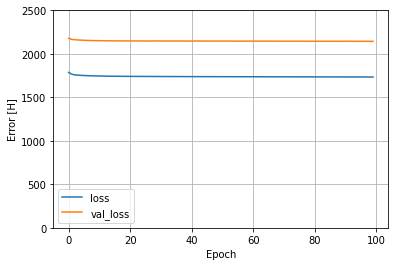

In [105]:
plot_loss(history)

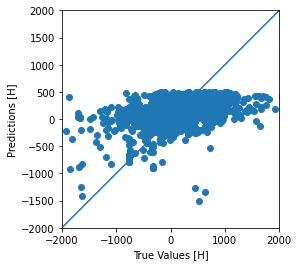

In [106]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [-2000, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Changing the search algorithm
Now our model is trained and ready to predict new values. It isn't very accurate, but with more games  
and more sofisticated heuristics it could increase his score.

In [109]:
#
# Predictive Alpha-Beta Pruning 
#

# init of the algorithm
def predictive_alpha_beta_algorithm(game, state, heuristics, depth = 3):
    
    def predictive_alpha_beta(game, state, depth, alpha, beta, maximizing_player):
        if game.is_terminal(state):
            return heuristics.h(game, state)
        if depth == 2:
            h_arr = heuristics.h_as_arr(game, state)
            prediction = dnn_model.predict(h_arr.reshape((1,6)))[0][0]
            return prediction
            

        if maximizing_player:
            max_eval = -np.inf
            for move in game.actions(state):
                new_state = game.result(state, move)
                eval = predictive_alpha_beta(game, new_state, depth - 1, alpha, beta, False)
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = np.inf
            for move in game.actions(state):
                new_state = game.result(state, move)
                eval = predictive_alpha_beta(game, new_state, depth - 1, alpha, beta, True)
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval


    # init
    max_move = None
    max_eval = -np.inf
    
    for move in game.actions(state):
        new_state = game.result(state, move)
        eval = predictive_alpha_beta(game, new_state, depth - 1, -np.inf, np.inf, False)
        if eval > max_eval:
            max_eval = eval
            max_move = move
            
    return max_eval, max_move

In [110]:
# our new player 
predictive_player = Player("PredictivePlayer", predictive_alpha_beta_algorithm, ChessHeuristics())

## Testing the predictive_player

In [113]:
report = play_chess_games(Chess(), dict(White=alpha_beta_player_depth3, Black=predictive_player), games_number=6, verbose=True)
df = pd.DataFrame(report)
df

Game 0 started
Game 0 ended in 192.12s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 1 started
Game 1 ended in 122.79s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 2 started
Game 2 ended in 115.39s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 3 started
Game 3 ended in 282.47s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 4 started
Game 4 ended in 194.77s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 5 started
Game 5 ended in 81.34s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)




,White,Black,final_state,winner,termination,game_time(s),total_moves
0,AlphaBetaPlayerDepth3,PredictivePlayer,5QR1/k6R/3PN1P1/PP1B4/4P3/8/8/4K3 b - - 0 47,White,Termination.CHECKMATE,192.12,93
1,AlphaBetaPlayerDepth3,PredictivePlayer,2kQ4/pp3p2/4N3/2pp4/1b6/2N5/PPP1PPPP/R3KB1R b ...,White,Termination.CHECKMATE,122.79,31
2,AlphaBetaPlayerDepth3,PredictivePlayer,5Q2/Rp2k3/1B6/5Q2/1p5N/1P6/1P2PPPP/4KB1R b K -...,White,Termination.CHECKMATE,115.39,41
3,AlphaBetaPlayerDepth3,PredictivePlayer,6Q1/1Q4p1/p1p3kR/3B4/3N1B2/8/PPP2bP1/2KR2N1 b ...,White,Termination.CHECKMATE,282.47,43
4,AlphaBetaPlayerDepth3,PredictivePlayer,2kr3Q/2R2p2/N1P4p/2b1p3/8/1P6/1PPP1PPP/2B1K1NR...,White,Termination.CHECKMATE,194.77,43
5,AlphaBetaPlayerDepth3,PredictivePlayer,4kb1r/pp2np2/3Np2p/B2pNbp1/2rP4/8/PPP1PPPP/R2Q...,White,Termination.CHECKMATE,81.34,21


### Results
Unfortunately our player isn't able to do smart moves as was expected. The model training didn't produce good   
accuracies, and that cause bad performances.

***
# Homework 2 - Solution 2
## Min-Max with predictive evaluation based on Stockfish Chess Engine
Initially we will collect a reasonable amount of states. Each state will be converted into a **3d array** containing  
key data about the board situation.  

At the end we'll have **two datasets**: one with the board configuration, and another with the values.  
These two datasets will be used to **train our model**.  

After the training, we will use the trained model to **predict** the kindness of every state that the Min-Max algorithm encounters.

In [114]:
squares_index = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
}

def square_to_index(square):
    """Converts a square like 'h3' to an integer index (17)"""
    letter = chess.square_name(square)
    return 8 - int(letter[1]), squares_index[letter[0]]

### Translating a board into meaningful data
The next function will translate a python chess board into a list of arrays representing meaningful data of the board.  
In particular, for every board, will be created **14 arrays of 8x8 arrays**. Twelve of them represent the position on the board for each type of piece, and for each player, while the remaining two represents the possible square to be attacked from player white and for player black respectively

In [115]:
def split_dims(board):
    """Converts a board into a 3d array"""
    board3d = np.zeros((14, 8, 8), dtype=np.int8)
    
    # adding pieces views
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = np.unravel_index(square, (8, 8))
            board3d[piece - 1][7 - idx[0]][idx[1]] = 1
        for square in board.pieces(piece, chess.BLACK):
            idx = np.unravel_index(square, (8, 8))
            board3d[piece + 5][7 - idx[0]][idx[1]] = 1
            
    # adding pieces attacks and valid moves
    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i,j = square_to_index(move.to_square)
        board3d[12][i][j] = 1
    board.turn = chess.BLACK
    
    for move in board.legal_moves:
        i,j = square_to_index(move.to_square)
        board3d[13][i][j] = 1
    board.turn = aux
    
    return board3d

In [116]:
# this function will create a random board of the given depth
def random_board(max_depth=150):
    board = chess.Board()
    depth = random.randrange(0, max_depth)

    for _ in range(depth):
        all_moves = list(board.legal_moves)
        random_move = random.choice(all_moves)
        board.push(random_move)
        if board.is_game_over():
            break

    return board

### Data example
Below is shown an example. The `split_dims` function is applied to a random board.   
The array generated is displayed.

In [117]:
board = random_board(max_depth=100)
display(split_dims(board))

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

## The dataset
The dataset we are going to use is already populated with pairs of board representation like descripted above,  
and an expert evaluation on the goodness of that situation. The expert used is the **Stockfish Chess Engine**.  

The dataset is composed of 1.500.000 boards, in form of the array as seen above, each one related to the value  
that the engine returns with a depth of 10.

In [118]:
def load_dataset(filename):
    """Returns the selected dataset ready for training"""
    container = np.load(filename)
    b, v = container["b"], container["v"]
    
    v = np.asarray(v / abs(v).max() / 2 + 0.5, dtype=np.float32) # normalization (0 - 1)
    
    return b, v

In [119]:
# our actual dataset to be used in the training
x_train, y_train = load_dataset("../dataset.npz")
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


### TensorFlow
Now that we have our dataset, we can start with machine learning.
For this part, TensorFlow will be used.  
Below the model used is defined.

In [120]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers

import tensorflow.keras.callbacks as callbacks

# this function will build our model
def build_model(conv_size, conv_depth):
    board3d = layers.Input(shape=(14, 8, 8))

    # adding the convolutional layers
    x = board3d
    for _ in range(conv_depth):
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, 'relu')(x)
    x = layers.Dense(1, 'sigmoid')(x)

    return models.Model(inputs=board3d, outputs=x)

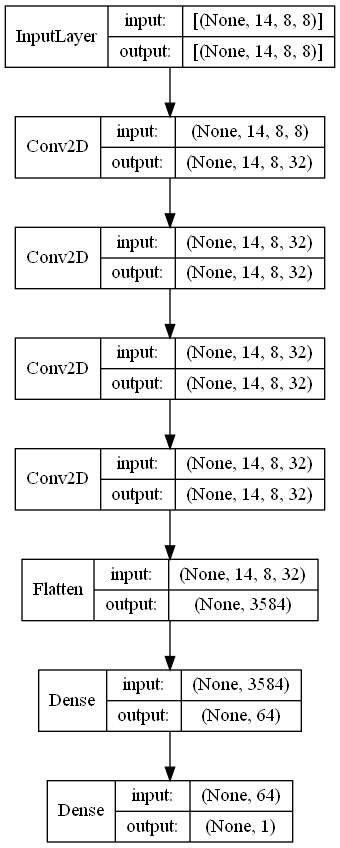

In [121]:
model = build_model(32, 4)
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

### Training

In [141]:
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=10,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

# storing our model into an h5 to not lose our long training info
model.save('model.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 8, 32)         2336      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten_1 (Flatten)         (None, 3584)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                2294

In [122]:
# loading the model

model = models.load_model("model.h5")

### Updating the search algorithm
Here we'll just change the evaluation function to call when the algorithm is analysing a given state.  
the rest of the algorithm does not change, but is proposed again here for convenience.

In [142]:
#
# Alpha-Beta Pruning with predictive evaluation
#

# this function will use the model and the incoming state to predict its value. 
# Note that this function is just an heuristic, it's not part of the algorithm itself.
def stockfish_eval(game, state):
    board = game.get_board(state)
    
    board3d = split_dims(board)
    board3d = np.expand_dims(board3d, 0)
    value = model.predict(board3d)[0][0]
    
    return value if board.turn else -value


#
# Predictive Alpha-Beta Pruning 
#

# init of the algorithm
def stockfish_alpha_beta_algorithm(game, state, heuristics, depth = 3):
    
    def stockfish_alpha_beta(game, state, depth, alpha, beta, maximizing_player):

        if depth == 1 or game.is_terminal(state):
     
            return stockfish_eval(game, state)
            

        if maximizing_player:
            max_eval = -np.inf
            for move in game.actions(state):
                new_state = game.result(state, move)
                eval = stockfish_alpha_beta(game, new_state, depth - 1, alpha, beta, False)
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = np.inf
            for move in game.actions(state):
                new_state = game.result(state, move)
                eval = stockfish_alpha_beta(game, new_state, depth - 1, alpha, beta, True)
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval


    # init
    max_move = None
    max_eval = -np.inf
    
    for move in game.actions(state):
        new_state = game.result(state, move)
        eval = stockfish_alpha_beta(game, new_state, depth - 1, -np.inf, np.inf, False)
        if eval > max_eval:
            max_eval = eval
            max_move = move
            
    return max_eval, max_move

### Playing with the Stockfish predictive player

In [143]:
stockfish_player = Player("StockfishPlayer", stockfish_alpha_beta_algorithm, ChessHeuristics())

## Stockfish predictive player vs AlphaBeta player with depth 3

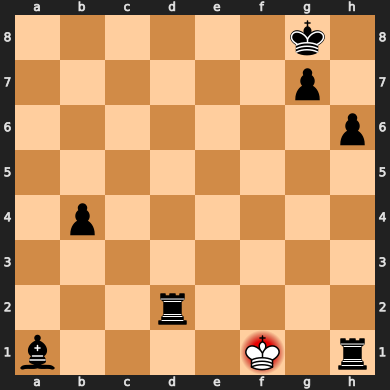

Player <Black> choosed the move: h4h1 with a value of 13514.88


'6k1/6p1/7p/8/1p6/8/3r4/b4K1r w - - 4 61'

In [149]:
play_game_live(Chess(), dict(White=stockfish_player, Black=alpha_beta_player_depth3), verbose = True)

## Results
The Stockfish predictive player isn't able to beat our Alpha-Beta player

## Stockfish predictive player vs Greedy

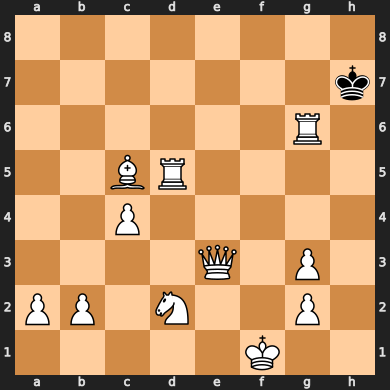

Player <White> choosed the move: e8e3 with a value of -0.9124354720115662


'8/7k/6R1/2BR4/2P5/4Q1P1/PP1N2P1/5K2 b - - 150 109'

In [150]:
play_game_live(Chess(), dict(White=stockfish_player, Black=greedy_player), verbose = True)

## Results
The stockfish predictive player is able to beat a greedy one.  

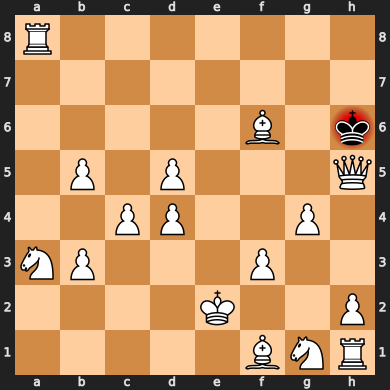

Player <White> choosed the move: f7h5 with a value of -0.9689633250236511


'R7/8/5B1k/1P1P3Q/2PP2P1/NP3P2/4K2P/5BNR b - - 150 179'

In [151]:
play_game_live(Chess(), dict(White=stockfish_player, Black=alpha_beta_player_depth2), verbose = True)

In [152]:
result = play_chess_games(Chess(), dict(White=stockfish_player, Black=alpha_beta_player_depth2), verbose=True, games_number=5)
df = pd.DataFrame(result)
df

Game 0 started
Game 0 ended in 1194.28s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 1 started
Game 1 ended in 2495.29s: Outcome(termination=<Termination.STALEMATE: 2>, winner=None)


Game 2 started
Game 2 ended in 1040.75s: Outcome(termination=<Termination.SEVENTYFIVE_MOVES: 4>, winner=None)


Game 3 started
Game 3 ended in 1506.42s: Outcome(termination=<Termination.SEVENTYFIVE_MOVES: 4>, winner=None)


Game 4 started
Game 4 ended in 970.29s: Outcome(termination=<Termination.SEVENTYFIVE_MOVES: 4>, winner=None)




,White,Black,final_state,winner,termination,game_time(s),total_moves
0,StockfishPlayer,AlphaBetaPlayerDepth2,6B1/1N6/1P4PB/6PP/2P2kQN/P7/P4P2/4RKR1 b - - 1...,White,Termination.CHECKMATE,1194.28,361
1,StockfishPlayer,AlphaBetaPlayerDepth2,3R4/8/BB1P1P2/PP1PNP1Q/2Q5/6k1/N7/5K1R b - - 1...,None,Termination.STALEMATE,2495.29,705
2,StockfishPlayer,AlphaBetaPlayerDepth2,4Q3/5Q2/2B1NB2/P4P2/1k6/7N/1PP2P1P/2KR2R1 w - ...,None,Termination.SEVENTYFIVE_MOVES,1040.75,238
3,StockfishPlayer,AlphaBetaPlayerDepth2,1k6/4B3/2PN4/Q1P2p2/1N3P1p/1P1P2P1/pP2BK1P/R4R...,None,Termination.SEVENTYFIVE_MOVES,1506.42,220
4,StockfishPlayer,AlphaBetaPlayerDepth2,8/8/1BB2k2/2PP1P2/1P3P1Q/2NP3P/PK2N3/2R1R3 b -...,None,Termination.SEVENTYFIVE_MOVES,970.29,233


## Results
The stockfish predictive player is able to beat the alpha-beta player with depth 2. It doesn't always dough, but atleast  
apparently never loses.